In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class TimeSeriesData():
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (self.xmax-self.xmin)/self.num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        
        # grab a random starting point for each button
        rand_start = np.random.rand(batch_size, 1)
        
        # convert to be on time series 
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        # Create batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0, steps+1)*self.resolution
        
        # create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        # formatting for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts 
        else:
            return y_batch[:, :-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

    

In [3]:
ts_data = TimeSeriesData(250, 0, 10)

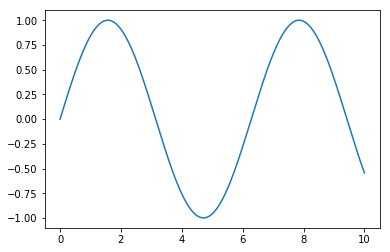

In [4]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [5]:
num_time_steps = 30

In [6]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

In [7]:
ts

array([[6.04020259, 6.08020259, 6.12020259, 6.16020259, 6.20020259,
        6.24020259, 6.28020259, 6.32020259, 6.36020259, 6.40020259,
        6.44020259, 6.48020259, 6.52020259, 6.56020259, 6.60020259,
        6.64020259, 6.68020259, 6.72020259, 6.76020259, 6.80020259,
        6.84020259, 6.88020259, 6.92020259, 6.96020259, 7.00020259,
        7.04020259, 7.08020259, 7.12020259, 7.16020259, 7.20020259,
        7.24020259]])

In [8]:
ts.flatten()

array([6.04020259, 6.08020259, 6.12020259, 6.16020259, 6.20020259,
       6.24020259, 6.28020259, 6.32020259, 6.36020259, 6.40020259,
       6.44020259, 6.48020259, 6.52020259, 6.56020259, 6.60020259,
       6.64020259, 6.68020259, 6.72020259, 6.76020259, 6.80020259,
       6.84020259, 6.88020259, 6.92020259, 6.96020259, 7.00020259,
       7.04020259, 7.08020259, 7.12020259, 7.16020259, 7.20020259,
       7.24020259])

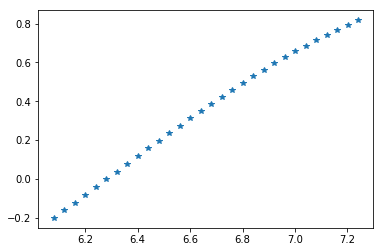

In [9]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

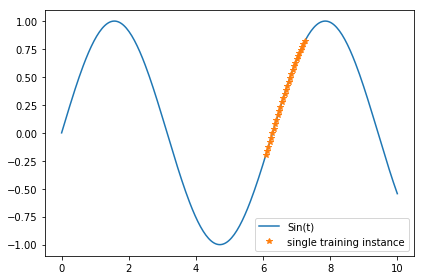

In [10]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*', label='single training instance'  )
plt.legend()
plt.tight_layout()

In [11]:
# training data
train_inst = np.linspace(5, 5+ ts_data.resolution*(num_time_steps+1),num_time_steps+1)

In [12]:
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

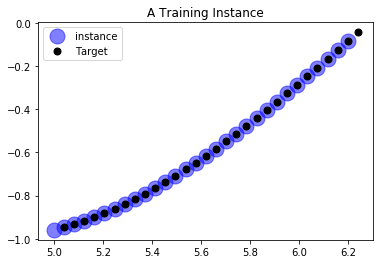

In [13]:
plt.title('A Training Instance')
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='instance')

plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]), 'ko', markersize=7,label='Target')
plt.legend()

# Creating a model

In [14]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_itr = 2000
batch_size = 1

In [15]:
#placeholders

In [16]:
X = tf.placeholder(tf.float32, [None,num_time_steps,num_inputs])

In [17]:
y = tf.placeholder(tf.float32, [None,num_time_steps,num_outputs])

# RNN cell layer

In [18]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,activation=tf.nn.relu)

In [19]:
#wrapping rnn cell to get only a single output insread of getting output from every neuron
cell = tf.contrib.rnn.OutputProjectionWrapper(cell,output_size=num_outputs)

In [20]:
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [21]:
# MSE
loss = tf.reduce_mean(tf.square(outputs-y))

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [23]:
train = optimizer.minimize(loss)

In [24]:
init = tf.global_variables_initializer()

In [25]:
# SESSION

In [26]:
saver = tf.train.Saver()

In [27]:
with tf.Session() as sess:
    sess.run(init)
    for ix in range(num_itr):
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict = {X:X_batch,y:y_batch})
        
        if ix % 100 == 0:
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(ix,"\tMSE",mse)
        #saver.save(sess,"./rnn_model")

0 	MSE 0.4778668
100 	MSE 0.105369076
200 	MSE 0.06920544
300 	MSE 0.012314351
400 	MSE 0.027238311
500 	MSE 0.0012472712
600 	MSE 0.0077359774
700 	MSE 0.019411482
800 	MSE 0.03998351
900 	MSE 0.017604154
1000 	MSE 0.0032810494
1100 	MSE 0.009487799
1200 	MSE 0.018538903
1300 	MSE 0.0005663856
1400 	MSE 0.0003868526
1500 	MSE 0.0106095355
1600 	MSE 0.019400563
1700 	MSE 0.0047234246
1800 	MSE 0.00077016035
1900 	MSE 0.0017783181


In [30]:
with tf.Session() as sess:
    saver.restore(sess,"./rnn_model/rnn_model")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_model/rnn_model


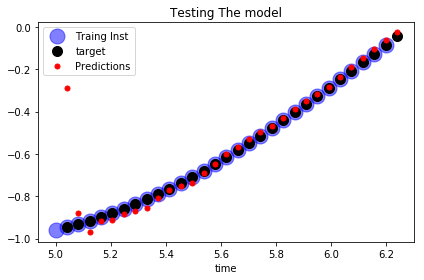

In [31]:
plt.title("Testing The model")
# Training instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15, alpha=0.5, label="Traing Inst")

# Target to predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label='target')

# Model Predictions
plt.plot(train_inst[1:],y_pred[0,:,0], "r." ,markersize=10,label="Predictions")
plt.xlabel('time')
plt.legend()
plt.tight_layout()

# Generating a New Squence

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_model/rnn_model")
    
    # seed zeros
    zero_seed = [0.0 for i in range(num_time_steps)]
    
    for ix in range(len(ts_data.x_data)-num_time_steps):
        X_batch = np.array(zero_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        
        zero_seed.append(y_pred[0,-1,0])
    

In [ ]:
plt.plot(ts_data.x_data,zero_seed,'b-')
plt.plot(ts_data.x_data[:num_time_steps],
        zero_seed[:num_time_steps],'r',linewidth=3)
plt.xlabel('time')
plt.ylabel('Y')